In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Ethereum (April-October 2023).csv").sort_values(by="Date")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-01,1821.704346,1840.173096,1811.118530,1813.860596,1813.860596,5556443606
1,2023-04-02,1821.192139,1824.328857,1774.872437,1795.708130,1795.708130,6199721188
2,2023-04-03,1794.922485,1839.157837,1765.518921,1810.297119,1810.297119,9643826401
3,2023-04-04,1810.142090,1886.594604,1802.955444,1871.005127,1871.005127,10398322335
4,2023-04-05,1870.965088,1937.497559,1865.941895,1909.114014,1909.114014,10319231689


In [4]:
df["Adj Close lag 1"] = df["Adj Close"].shift(1)
df["Adj Close lag 2"] = df["Adj Close"].shift(2)
df["Adj Close lag 3"] = df["Adj Close"].shift(3)
df["Adj Close lag 4"] = df["Adj Close"].shift(4)
df["Adj Close lag 5"] = df["Adj Close"].shift(5)
df = df.dropna()

In [5]:
print(df["Date"].max())

2023-10-18


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close lag 1,Adj Close lag 2,Adj Close lag 3,Adj Close lag 4,Adj Close lag 5
5,2023-04-06,1909.143555,1909.271729,1857.085083,1872.922607,1872.922607,8263191830,1909.114014,1871.005127,1810.297119,1795.708130,1813.860596
6,2023-04-07,1872.734131,1882.299194,1845.993896,1865.636108,1865.636108,8356130492,1872.922607,1909.114014,1871.005127,1810.297119,1795.708130
7,2023-04-08,1864.679077,1879.107788,1848.875488,1849.498169,1849.498169,5016362733,1865.636108,1872.922607,1909.114014,1871.005127,1810.297119
8,2023-04-09,1849.672241,1873.057373,1828.700073,1859.387817,1859.387817,6361497715,1849.498169,1865.636108,1872.922607,1909.114014,1871.005127
9,2023-04-10,1859.741211,1917.300171,1848.164185,1911.207520,1911.207520,8380134275,1859.387817,1849.498169,1865.636108,1872.922607,1909.114014


In [7]:
df["Date"] = pd.to_datetime(df["Date"]).dt.to_period("d").astype("int64")

In [8]:
y = df["Adj Close"].to_numpy().reshape(-1, 1)
X = df[["Date", "Adj Close lag 1", "Adj Close lag 2", "Adj Close lag 3", "Adj Close lag 4", "Adj Close lag 5"]]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
full_dates = X["Date"].values.astype('datetime64[D]')
train_dates = X_train["Date"].values.astype('datetime64[D]')
val_dates = X_val["Date"].values.astype('datetime64[D]')

In [11]:
X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train).astype("float64")
y_train = y_train.reshape(-1, 1).astype("float64")
X_val = X_scaler.transform(X_val).astype("float64")
y_val = y_val.reshape(-1, 1).astype("float64")

In [12]:
y_train.shape

(156, 1)

In [13]:
X_train.shape

(156, 6)

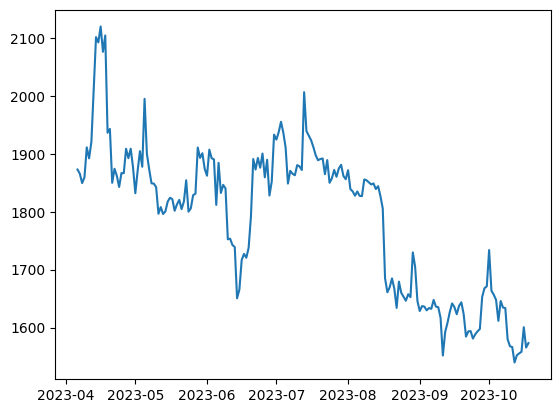

In [14]:
fig, ax = plt.subplots() 
ax.plot(full_dates, y)

In [15]:
def plot(target, output, dates=train_dates):
    """plot with real and predicted values"""
    plt.plot(dates, target, label='y_train')
    plt.plot(dates, output, label='y_pred')
    plt.title('')
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.legend()
    plt.show()

In [16]:
INPUT_DIM = 6
OUT_DIM = 1
H_DIM_1 = 20

def elu(x, alpha = 0.01):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha = 0.01):
    return (elu(x,alpha)+alpha)*(x<=0)+(x>0)

def error_derivative(y_pred, y_true):
    return 2 * (y_true - y_pred)

def get_MSE(y_pred, y_true):
    return np.mean((y_true - y_pred) ** 2)


W1 = np.random.rand(INPUT_DIM, H_DIM_1)
b1 = np.random.rand(1, H_DIM_1)
W2 = np.random.rand(H_DIM_1, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM_1)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM_1)


ALPHA = 0.000001
NUM_EPOCHS = 10000
BATCH_SIZE = 32

loss_arr = []

for ep in range(NUM_EPOCHS):
    for batch_num in range(len(X_train) // BATCH_SIZE + bool(len(X_train) // BATCH_SIZE)):
        X_batch = X_train[batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + BATCH_SIZE]
        y_batch = y_train[batch_num*BATCH_SIZE : batch_num*BATCH_SIZE + BATCH_SIZE]
        # Forward
        t1 = X_batch @ W1 + b1
        h1 = elu(t1)
        t2 = h1 @ W2 + b2
        E = np.sum(error_derivative(t2, y_batch))

        # Backward
        dE_dt2 = t2 - y_batch
        dE_dW2 = h1.T @ dE_dt2
        dE_db3 = np.sum(dE_dt2, axis=0, keepdims=True)

        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * elu_derivative(t1)
        dE_dW1 = X_batch.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Weights update
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db3

    loss_arr.append(E)
    if ep % 2000 == 0:
        print(f"Epoch:{ep}")
        y_train_predict = elu(X_train @ W1 + b1) @ W2 + b2
        y_val_predict = elu(X_val @ W1 + b1) @ W2 + b2
        print("Train MSE:", get_MSE(y_train_predict, y_train))
        print("Val MSE:", get_MSE(y_val_predict, y_val))


def predict(x_in):
    t1 = x_in @ W1 + b1
    h1 = elu(t1)
    t2 = h1 @ W2 + b2
    return t2


print("Result train MSE:", get_MSE(predict(X_train), y_train))
print("Result val MSE:", get_MSE(predict(X_val), y_val))


Epoch:0
Train MSE: 3377257.4990059664
Val MSE: 2595824.517957731
Epoch:2000
Train MSE: 1400.745687569183
Val MSE: 747.7493651327056
Epoch:4000
Train MSE: 1357.9826183923628
Val MSE: 775.3993433231024
Epoch:6000
Train MSE: 1350.1584205402214
Val MSE: 783.4877112286179
Epoch:8000
Train MSE: 1344.6573739106634
Val MSE: 787.173636313976
Result train MSE: 1337.0891947404075
Result val MSE: 788.240880121446


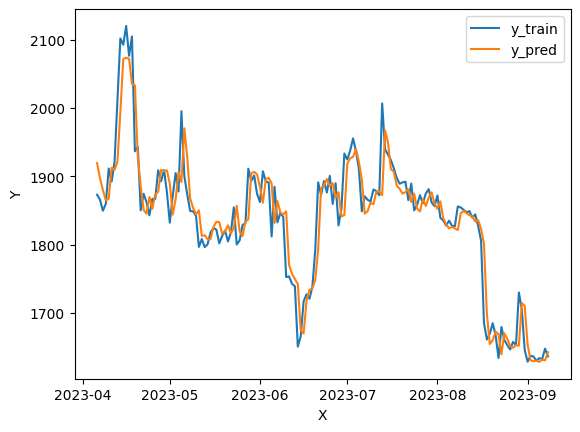

In [17]:
plot(y_train, predict(X_train))

MSE val: 788.240880121446


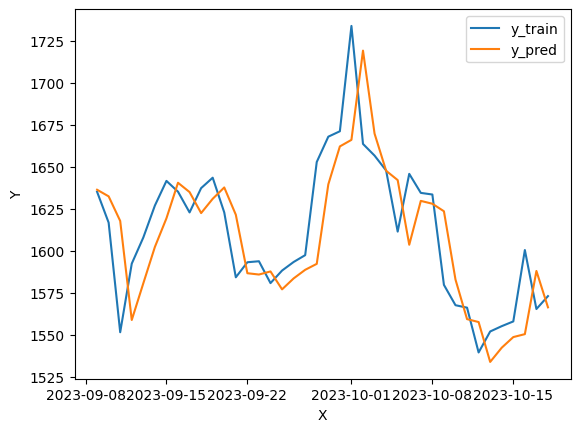

In [18]:
print("MSE val:", get_MSE(predict(X_val), y_val))
plot(y_val, predict(X_val), val_dates)

In [19]:
y_train_predict = predict(X_train)
y_val_predict = predict(X_val)

In [20]:
print("RMSE train:", np.sqrt(get_MSE(y_train, y_train_predict)))
print("RMSE validation:", np.sqrt(get_MSE(y_val, y_val_predict)))

RMSE train: 36.56623025060701
RMSE validation: 28.075627866914143
